In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [3]:
trainloader = torch.utils.data.DataLoader(dataset=trainset,batch_size=4,
                                         shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(dataset=testset,batch_size=4,shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(trainset[100][0])

<Figure size 640x480 with 1 Axes>

## Defining the Convolutional Neural Network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,160)
        self.fc2 = nn.Linear(160,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=160, bias=True)
  (fc2): Linear(in_features=160, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

### Train the network

In [50]:
for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs) ## why not net.forward(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.764
[1,  4000] loss: 1.647
[1,  6000] loss: 1.544
[1,  8000] loss: 1.489
[1, 10000] loss: 1.458
[1, 12000] loss: 1.401
[2,  2000] loss: 1.334
[2,  4000] loss: 1.341
[2,  6000] loss: 1.292
[2,  8000] loss: 1.290
[2, 10000] loss: 1.257
[2, 12000] loss: 1.237
Finished Training


In [51]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network

In [52]:
# load the previously trained network to get the weights
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)


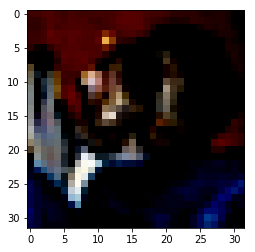

In [10]:
test_iter = iter(testloader)
test_img,test_label = next(test_iter)
print(np.shape(test_img.numpy()))
plt.imshow(np.transpose(test_img.numpy(),(0,2,3,1))[0])
#outputs = net()

In [53]:
test_error = 0
with torch.no_grad():
    for _,data in enumerate(testloader,0):
        test_img,test_label = data
        test_out = net(test_img)
        test_prediction = torch.argmax(test_out,1)
        test_error += (test_prediction != test_label).sum().item()
        
print(test_error)

4321


In [56]:
print('Test Error %f'%(test_error/len(testset)))

Test Error 0.432100


## Let's do the same on the GPU

In [71]:
## Find whether a GPU is available or not
torch_device = "cpu"
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(device)
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_capability())
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties(device))
    
    # getting the default cuda device
    torch_device = torch.device('cuda:0')

0
1
(6, 1)
GeForce GTX 1050 Ti with Max-Q Design
_CudaDeviceProperties(name='GeForce GTX 1050 Ti with Max-Q Design', major=6, minor=1, total_memory=4042MB, multi_processor_count=6)


In [72]:
torch_device

device(type='cuda', index=0)

In [92]:
## retrain on GPU
# sending network to the GPU
net_gpu = Net()
net_gpu.to(torch_device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_gpu.parameters(),lr=0.001,momentum=0.9)

for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels = data[0].to(torch_device),data[1].to(torch_device)
        #inputs,labels = data
        #inputs = inputs.to(torch_device)
        #labels = labels.to(torch_device)
        
        optimizer.zero_grad()
        outputs = net_gpu(inputs) ## why not net.forward(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.182
[1,  4000] loss: 1.840
[1,  6000] loss: 1.682
[1,  8000] loss: 1.581
[1, 10000] loss: 1.501
[1, 12000] loss: 1.445
[2,  2000] loss: 1.379
[2,  4000] loss: 1.343
[2,  6000] loss: 1.326
[2,  8000] loss: 1.291
[2, 10000] loss: 1.311
[2, 12000] loss: 1.280
Finished Training


In [93]:
next(net_gpu.parameters()).is_cuda

True

In [95]:
# Testing on the GPU
test_error = 0
with torch.no_grad():
    for _,data in enumerate(testloader,0):
        test_img,test_label = data[0].to(torch_device),data[1].to(torch_device)
        test_out = net_gpu(test_img)
        test_prediction = torch.argmax(test_out,1)
        test_error += (test_prediction != test_label).sum().item()

In [96]:
print(test_error)

4502
